In [1]:
# imports

%load_ext autoreload
%autoreload 2

import time
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from consav.misc import elapsed

from HANKStickyModel import HANKStickyModelClass

# General equilirbium decomposition for fiscal policy
Try out code for the general equilibrium decomposition of fiscal policy.

In [2]:
# solve example models

updated_par = {'phi_G': 0.7,  # mixed financing of fiscal policy shock
               'jump_eg': 0.01,  # 1% government spending shock
               'rho_eg': 0.9,
               'jump_em': 0.0,
               'taylor': 'linear'}
model = HANKStickyModelClass(name='baseline', par={**updated_par, **{'inattention': 0.0}})
print("\r" + 'Find steady state  ', end="")
model.find_ss(do_print=False)
# model without sticky information
print("\r" + 'Compute Jacobians (no sticky) ', end="")
model.compute_jacs(do_print=False)
print("\r"+'Find IRFs (no sticky)          ',end="")
model.find_IRFs(do_print=False)

# model with sitcky information
# model_sticky = model.copy()  # steady state unaffected by sticky information
# model_sticky.par.inattention = 0.935
# print("\r" + 'Compute Jacobians (sticky)    ', end="")
# model_sticky.compute_jacs(do_print=False)
# print("\r"+'Find transition path (sticky)    ',end="")
# model_sticky.find_transition_path(do_print=False, do_print_unknowns=False)
# print("\r"+'Find IRFs (sticky)               ',end="")
# model_sticky.find_IRFs(do_print=False)
print("\r" + 'Done                     ', end="")

Done                           

In [3]:
ss = model.ss
par = model.par

In [4]:
for k in model.jac.keys():
    if 'C_hh' == k[0]:
        print(f"{k}, only zeros: {np.isclose(model.jac[k], 0.0).all()}")


('C_hh', 'r'), only zeros: False
('C_hh', 'w'), only zeros: False
('C_hh', 'Y'), only zeros: False
('C_hh', 'Ip'), only zeros: False
('C_hh', 'Q'), only zeros: True
('C_hh', 'eg'), only zeros: True
('C_hh', 'em'), only zeros: True
('C_hh', 'ez'), only zeros: False
('C_hh', 'eg_direct'), only zeros: True
('C_hh', 'eg_distribution'), only zeros: False
('C_hh', 'eg_debt'), only zeros: False


# Simple decomposition based on market clearing condition

The Jacobian for Y as output are all zero.
On the other hand, the IRF for dY is equal to the values that jac[('Y', 'eg')] should have IF eg is the only shock that has realizations different from zero.

In any case, the Jacobians with Y as input can be reconstructed using the goods market clearing condition.
$$Y_{t}=C_{t}+G_{t}+I_{t}+I_{t}S\left(\frac{I_{t}}{I_{t-1}}\right)+\zeta L_{t-1}$$

In [6]:
def decompose_Y(model, plot_dY=True, return_dY=False, set_jacs_zero=[]):
    """ decompose output in based on market clearing elements"""

    for j in set_jacs_zero:
        assert j in model.jac.keys(), f'{j} not in jac.keys()'

    if plot_dY:
        fig, ax = plt.subplots()
        ax.set_xlabel('t')
        ax.set_ylabel('in % of ss.Y')
        ax.set_title('Output response decomposition')

    dY = np.zeros_like(model.IRF['Y'])
    inputs_good_market_clearing = ['C_hh', 'G', 'I', 'psi', 'L_hh']
    for varname in inputs_good_market_clearing:
        d_input = np.zeros_like(model.IRF[varname])
        for inputname in model.shocks + model.unknowns:
            # print(f"{(varname, inputname)}")
            if (varname, inputname) in set_jacs_zero:
                # print(f"{(varname, inputname)} to zero")
                d_input[:] += 0.0
            else:
                d_input[:] += model.jac[(varname, inputname)] @ model.IRF[inputname]

        # assert (d_input == model.IRF[varname]).all(), f"{varname} max abs diff: {abs(d_input - model.IRF[varname]).max()}"

        if varname == 'L_hh':
            d_input[:] = par.xi * np.hstack((0.0, d_input[:-1]))

        dY += d_input
        if plot_dY:
            ax.plot(np.arange(par.T), d_input/ss.Y, label=varname, linestyle='--')

    if plot_dY:
        ax.plot(np.arange(par.T), dY/ss.Y, label='Y', linestyle='-')
        ax.legend()

    if len(set_jacs_zero) == 0:
        # print(dY, model.IRF['Y'])
        assert np.isclose(dY, model.IRF['Y']).all()

    if return_dY:
        return dY

('Y', 'r'), only zeros: True
('Y', 'w'), only zeros: True
('Y', 'Y'), only zeros: False
('Y', 'Ip'), only zeros: True
('Y', 'Q'), only zeros: True
('Y', 'eg'), only zeros: True
('Y', 'em'), only zeros: True
('Y', 'ez'), only zeros: True
('Y', 'eg_direct'), only zeros: True
('Y', 'eg_distribution'), only zeros: True
('Y', 'eg_debt'), only zeros: True
Schock eg_direct has a non-zero trajectory.
Schock eg_distribution has a non-zero trajectory.
Schock eg_debt has a non-zero trajectory.


AssertionError: 

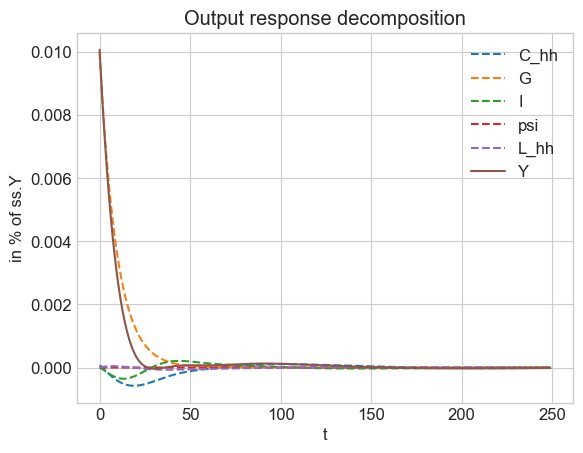

In [12]:
for k in model.jac.keys():
    if 'Y' == k[0]:
        print(f"{k}, only zeros: {np.isclose(model.jac[k], 0.0).all()}")

for e in model.shocks:
    if e != 'eg' and not np.isclose(model.IRF[e], 0.0).all():
        print(f"Schock {e} has a non-zero trajectory.")

decompose_Y(model, plot_dY=True)

Problem with this decomposition:
It does not reflect the source of the respective changes.
If we look at the change in investment, this change in investment can have different sources:
1. Crowding out
2. Change in investment demand through higher output (which could come from the direct government spending effect on demand, the consumpton response, ...)
Given the simple decomposition based on the goods market clearing, we can not separate, where this effect comes from.

# General equilibrium decomposition

### shocks ###


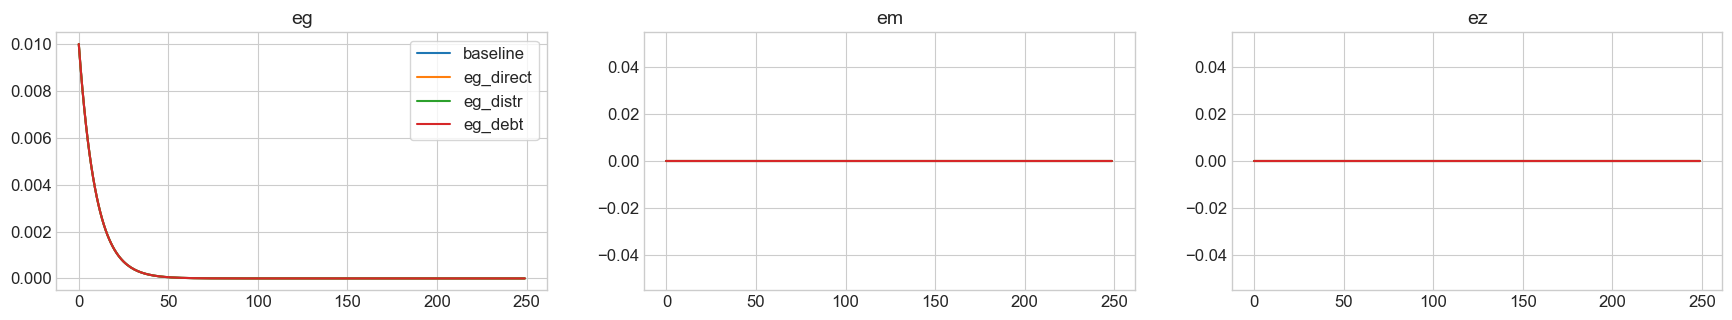


### varnames ###


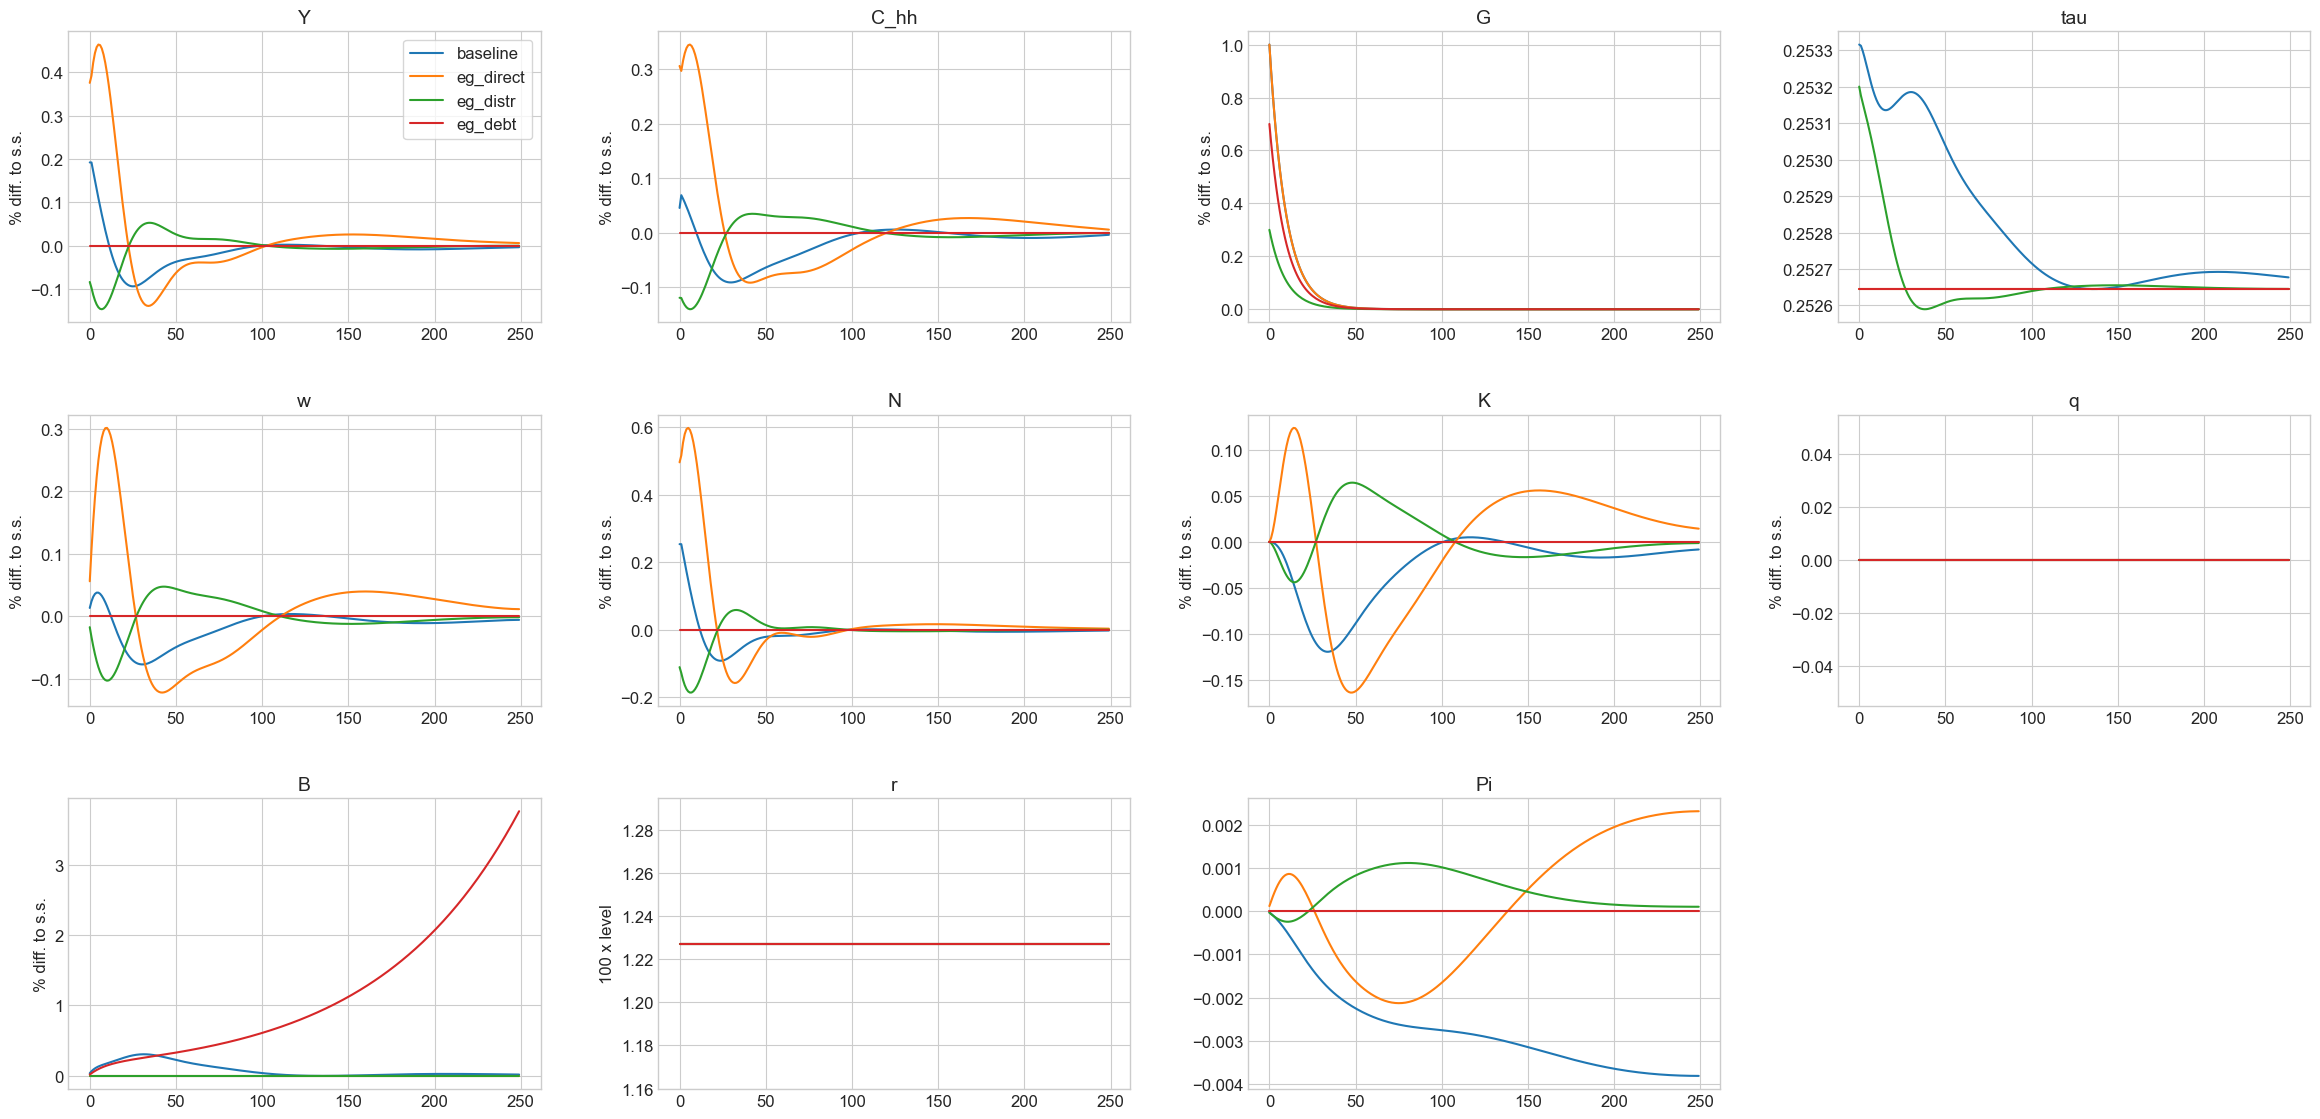


### shocks ###


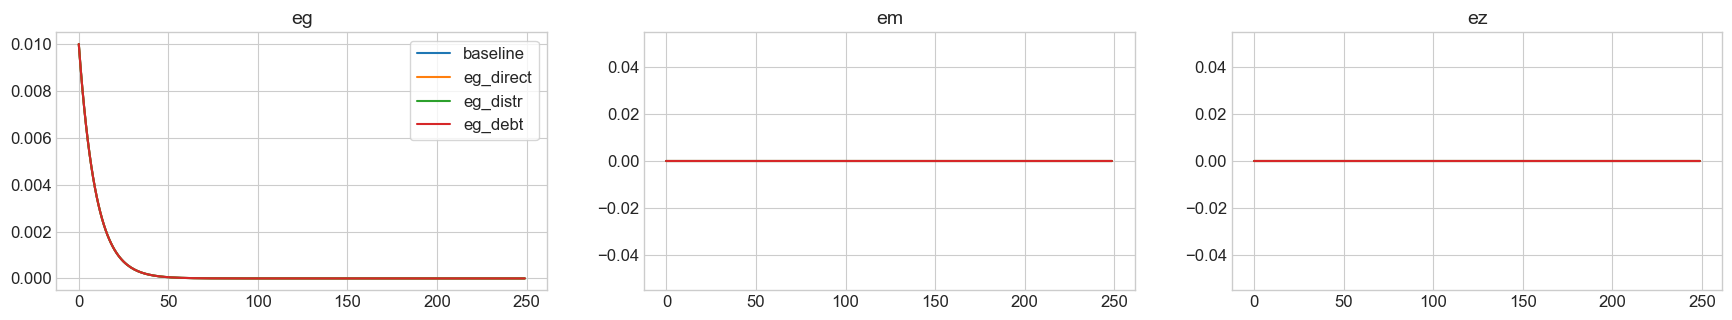


### varnames ###


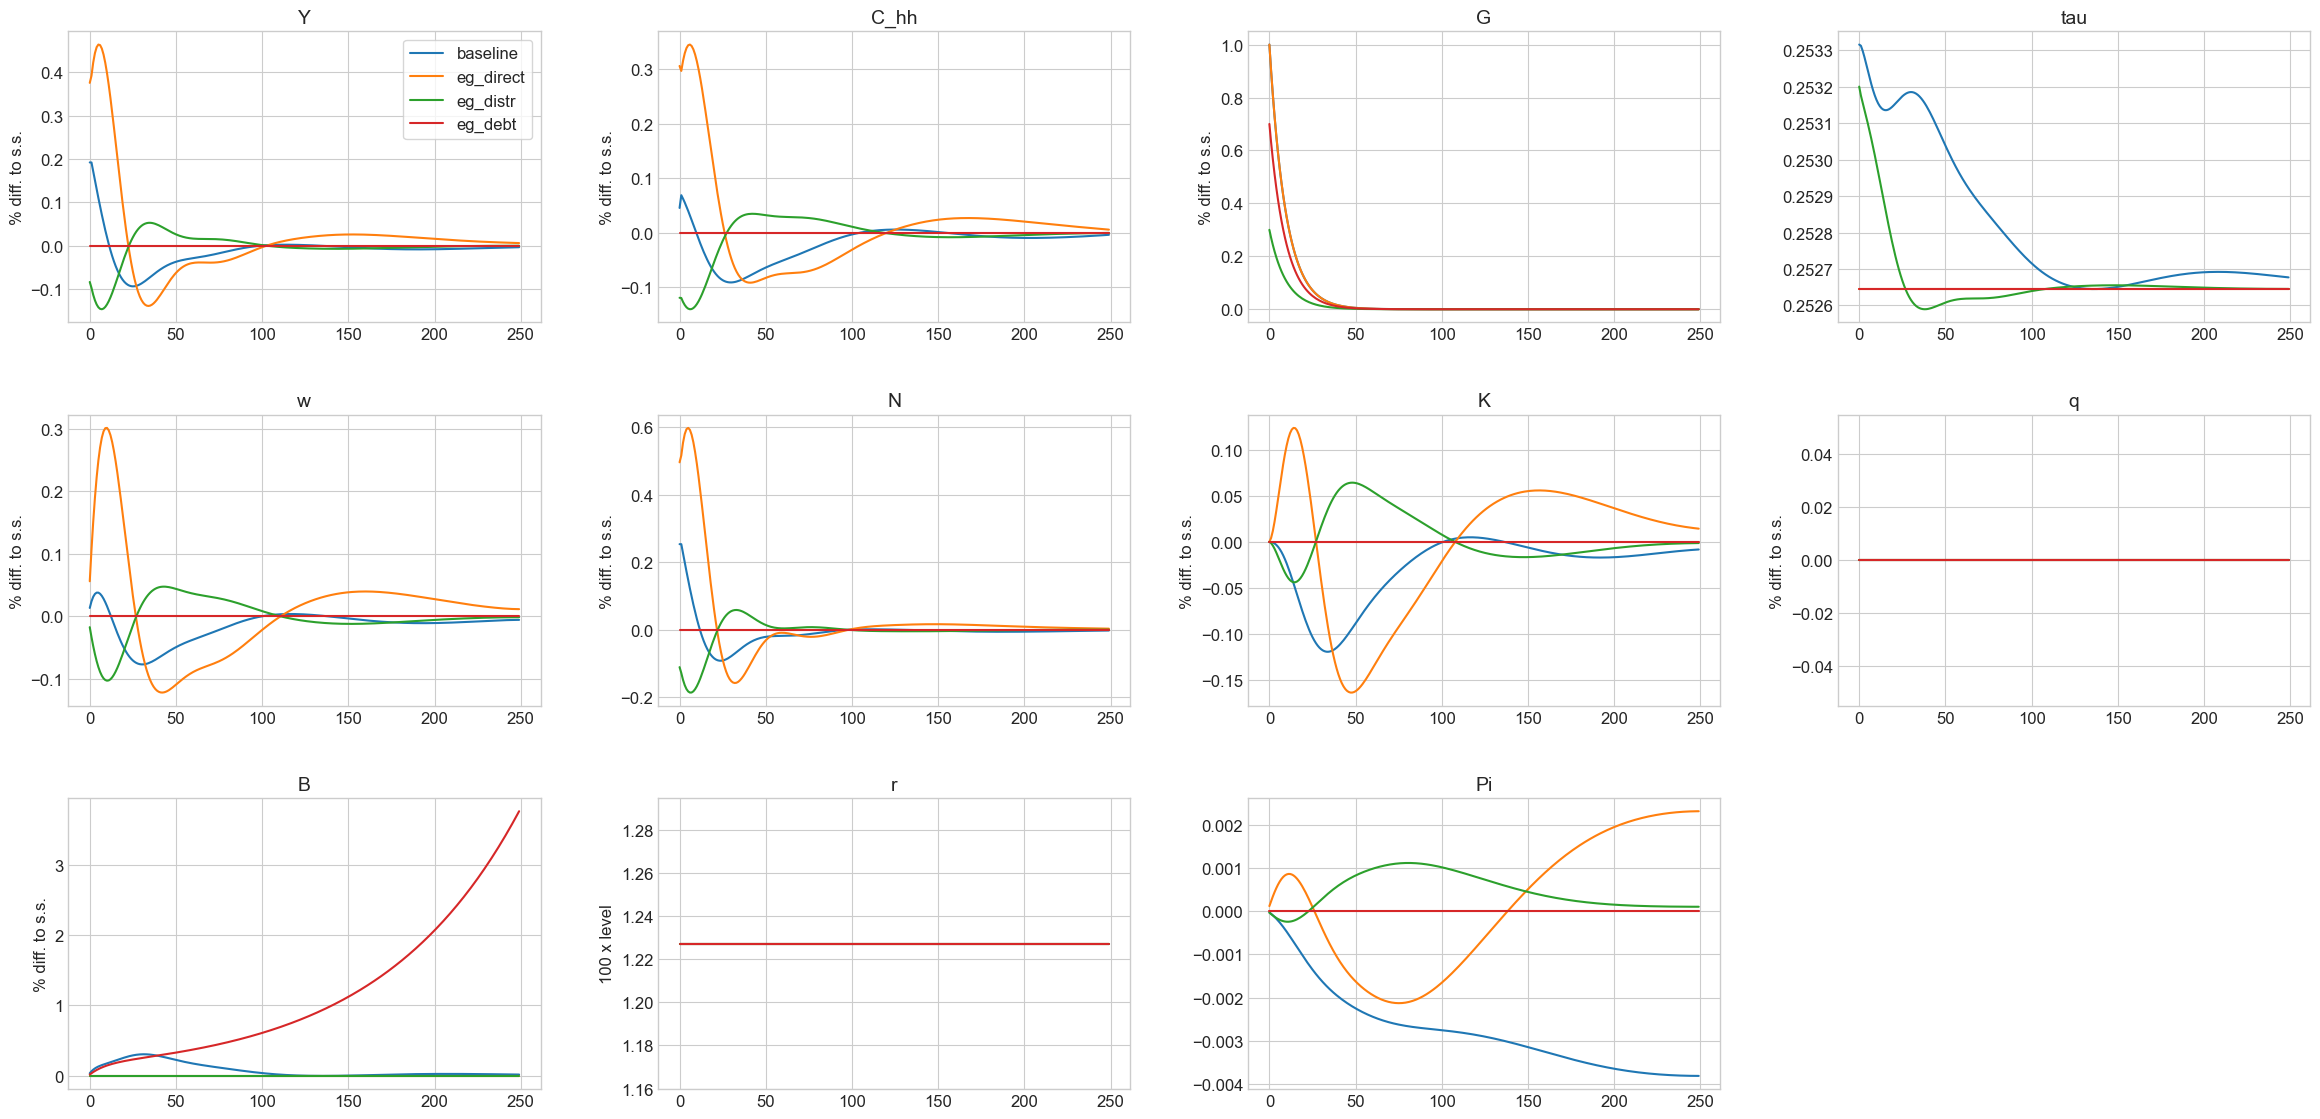


direct
distribution
debt
### shocks ###


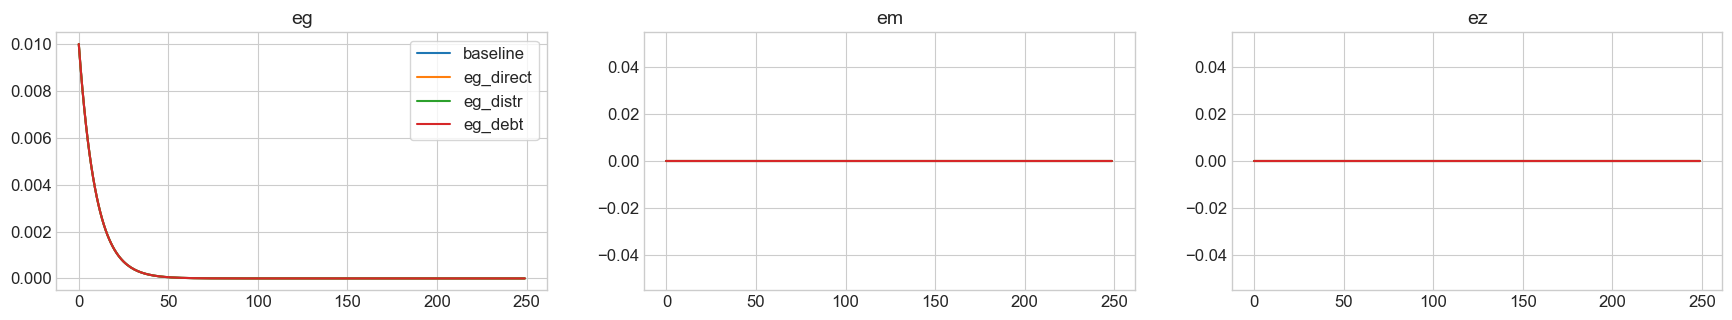


### varnames ###


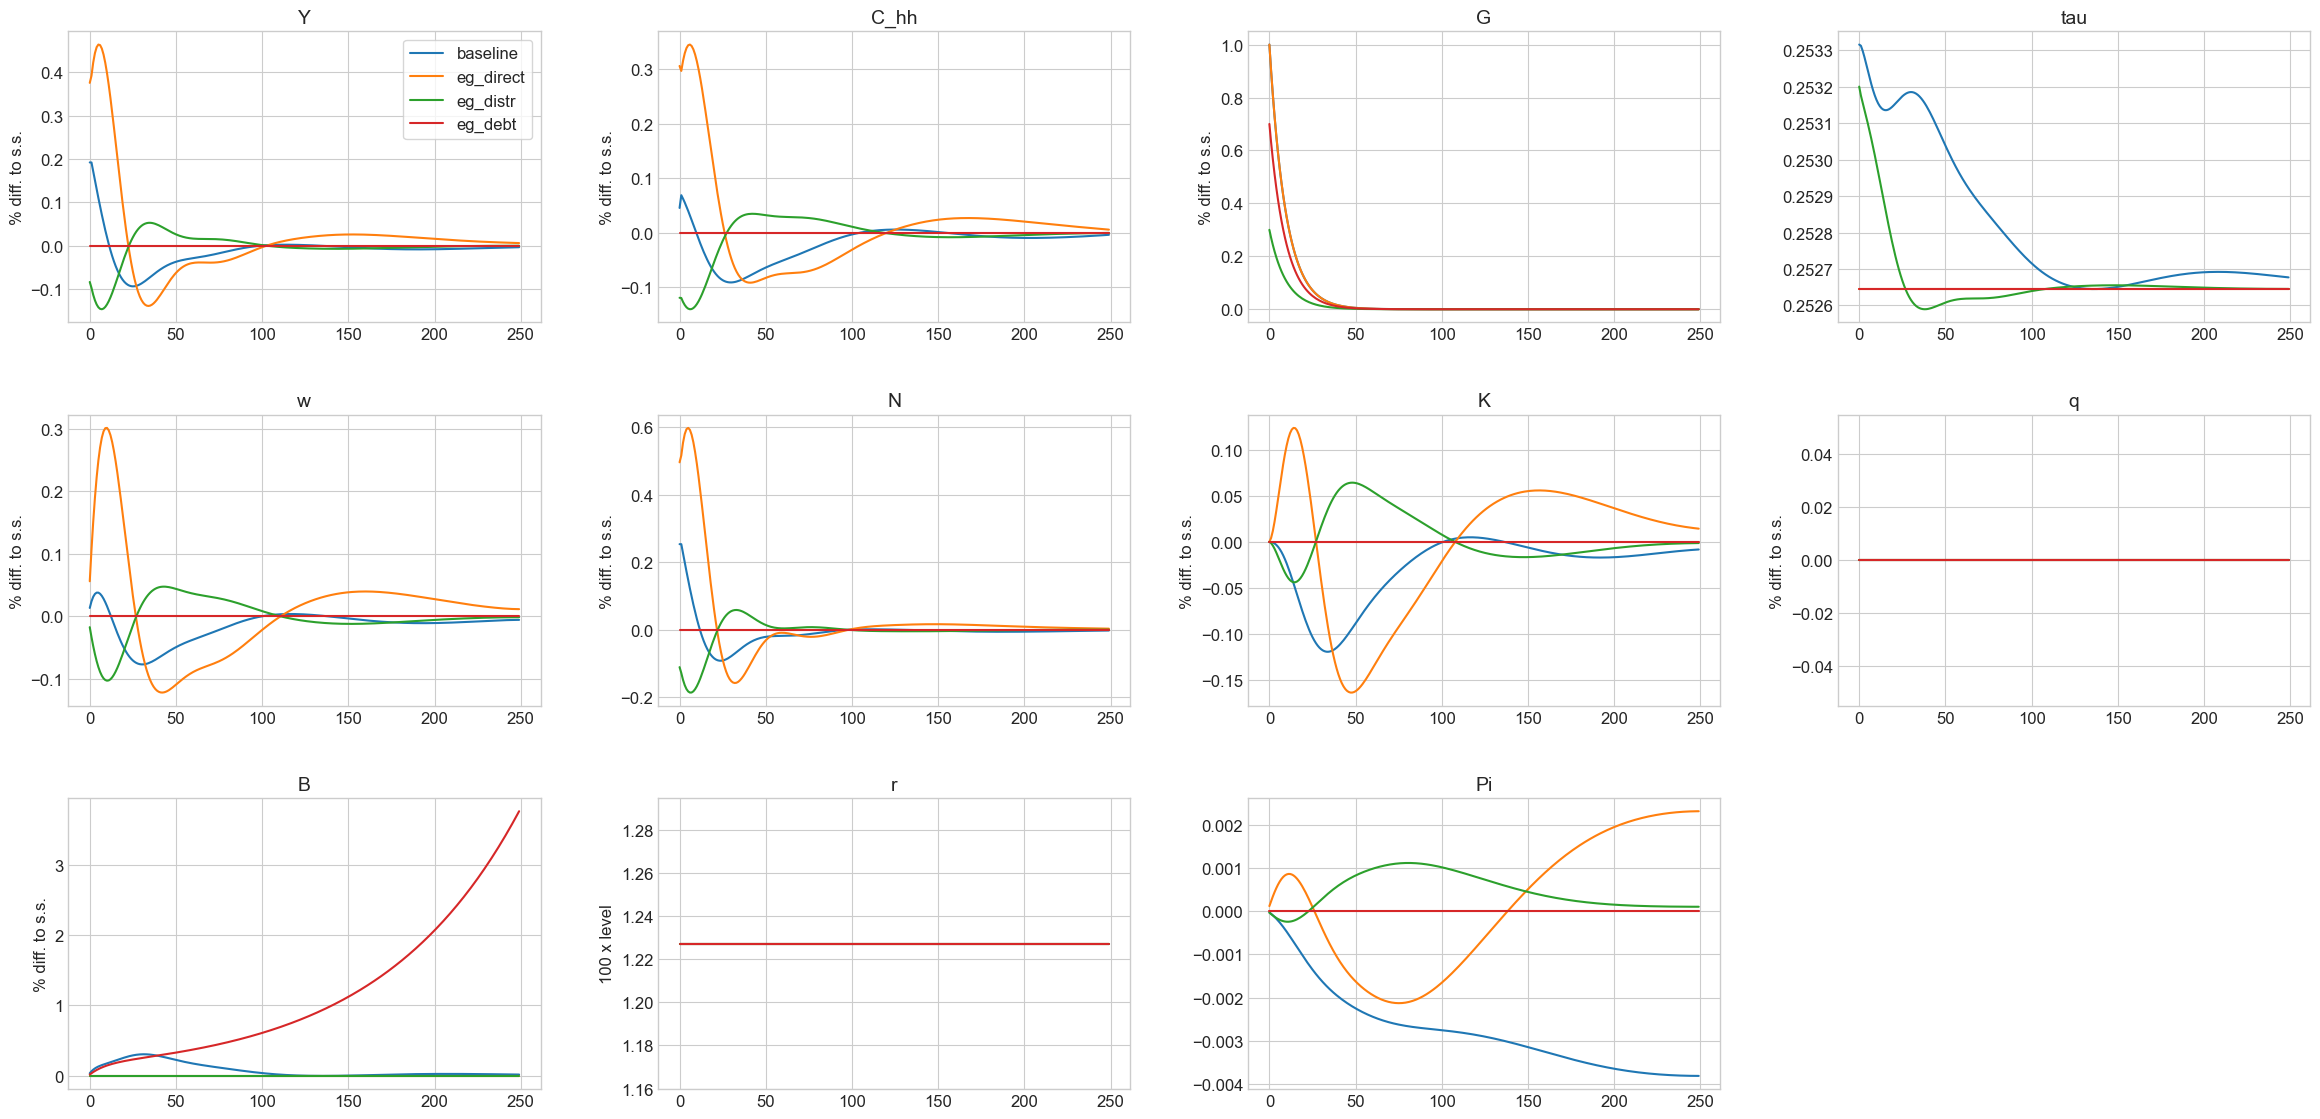

In [11]:
print("direct")
model_eg_direct = model.copy()
model_eg_direct.par.decomp_direct = True
model_eg_direct.compute_jacs()
model_eg_direct.find_IRFs()

print("distribution")
model_eg_distribution = model.copy()
model_eg_distribution.par.decomp_distribution = True
model_eg_distribution.compute_jacs()
model_eg_distribution.find_IRFs()

print("debt")
model_eg_debt = model.copy()
model_eg_debt.par.decomp_debt = True
model_eg_debt.compute_jacs()
model_eg_debt.find_IRFs()


### shocks ###


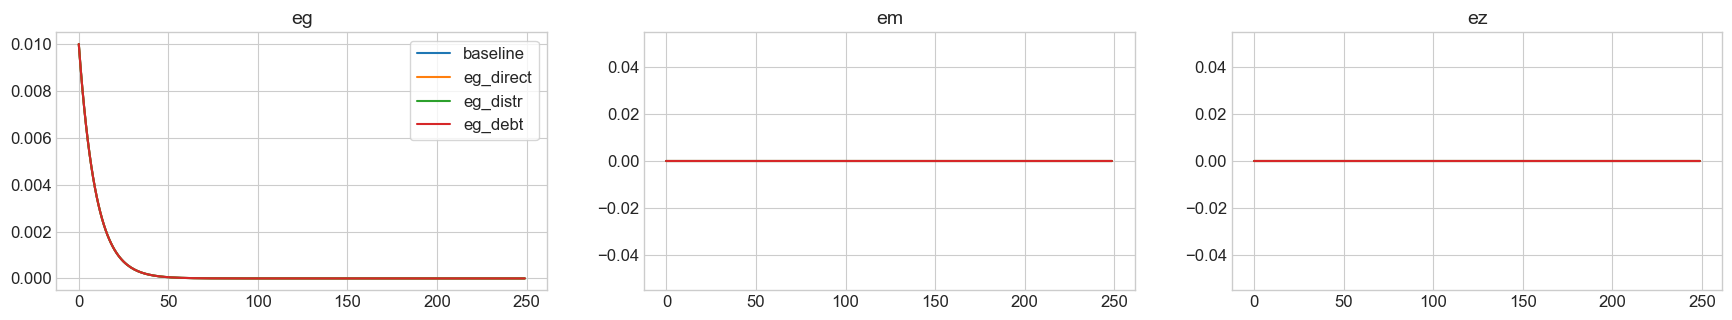


### varnames ###


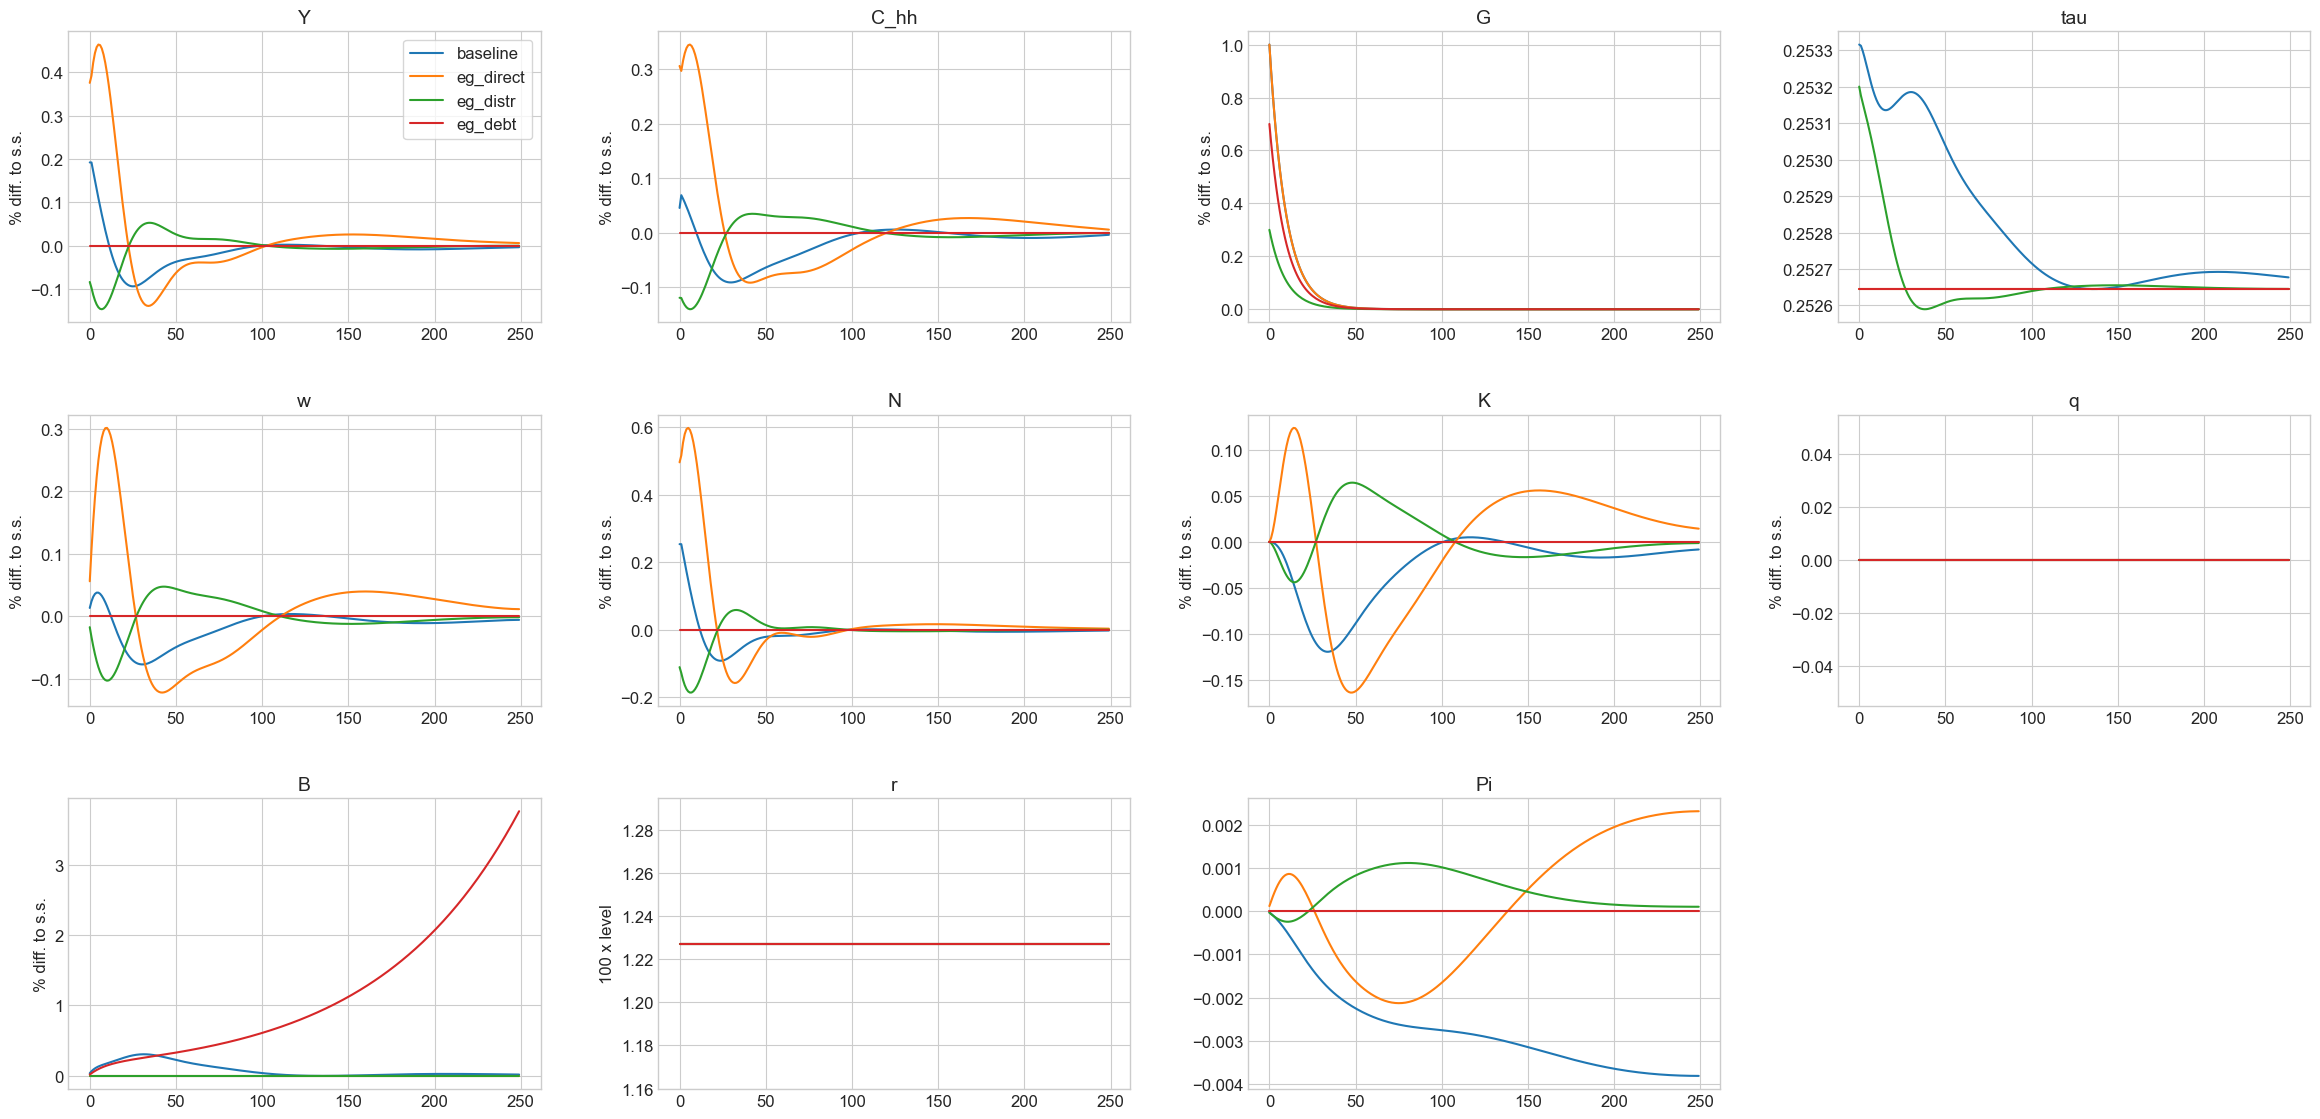

In [18]:
models = [model, model_eg_direct, model_eg_distribution, model_eg_debt]
labels = ['baseline', 'eg_direct', 'eg_distr', 'eg_debt']
paths = ['Y', 'C_hh', 'G', 'tau', 'w', 'N', 'K', 'q', 'B', 'r', 'Pi']
lvl_value = ['eg', 'eg_direct', 'eg_distribution', 'eg_debt', 'ez', 'em', 'r', 'tau', 'Pi']
facs = {'r': 100}
model.compare_IRFs(models, labels, paths, lvl_value=lvl_value, facs=facs,
                   do_linear=True, do_non_linear=False, do_targets=False)

In [14]:
dY = np.empty_like(model.IRF['Y'])
for m in [model_eg_direct, model_eg_distribution, model_eg_debt]:
    dY += m.IRF['Y']
dY - model.IRF['Y']

array([ 9.96345745e-004,  1.02577847e-003,  1.37741809e-003,
        1.67563685e-003,  1.92210636e-003,  2.11808807e-003,
        2.26575324e-003,  2.36789326e-003,  2.42774521e-003,
        2.44888286e-003,  2.43511275e-003,  2.39039042e-003,
        2.31873487e-003,  2.22415920e-003,  2.11060448e-003,
        1.98188364e-003,  1.84163173e-003,  2.89410469e+292,
        1.53995371e-003, -7.53035784e+245,  1.22981187e-003,
        1.07789364e-003,  9.30842210e-004,  7.90348115e-004,
        6.57801827e-004,  5.34304249e-004,  4.20680876e-004,
        3.17499012e-004,  2.25087445e-004,  1.43557971e-004,
        7.28281887e-005,  1.40799934e+228, -3.73915150e-005,
        1.53730213e+115, -1.09217794e-004, -1.32332357e-004,
       -1.47906832e-004, -1.56737298e-004, -1.59639473e-004,
       -1.57432459e-004, -1.50924257e-004, -1.40899113e-004,
       -1.28106728e-004, -1.13253284e-004, -9.69942570e-005,
       -7.99289062e-005, -6.25963698e-005, -4.54732280e-005,
       -2.89724273e-005,

In [15]:
model_eg_debt.IRF['Y']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## Old Try


In [7]:
def decompose_GE(model, unkown: str, shock: str):
    assert unkown in model.unknowns, 'Outputvariable needs to be an unkown'
    d_unkown = np.zeros_like(model.IRF[unkown])
    i_unknown = model.unknowns.index(unkown)

    assert shock in model.shocks, 'Shock not in model.shocks'
    d_shock = model.IRF[shock]
    i_shock = model.shocks.index(shock)
    # print(np.isclose(d_shock, 0.0).all())

    G_U_relevant = model.G_U[i_unknown*par.T:(i_unknown+1)*par.T, i_shock*par.T:(i_shock+1)*par.T]
    # print(np.isclose(G_U_relevant, 0.0).all())

    d_unkown += G_U_relevant @ d_shock

    return d_unkown

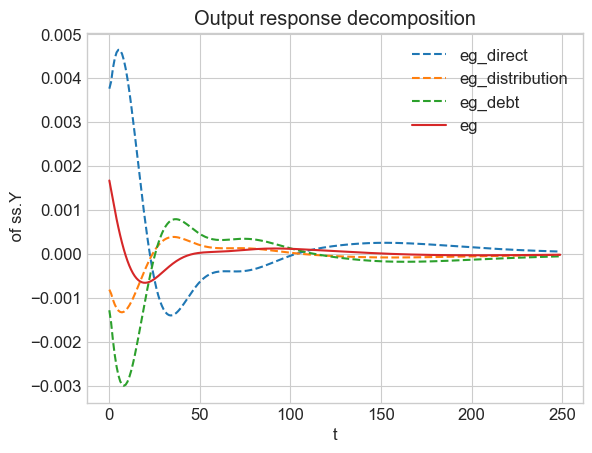

In [8]:
dY = np.zeros_like(model.IRF['Y'])
fig, ax = plt.subplots()
ax.set_xlabel('t')
ax.set_ylabel(' of ss.Y')
ax.set_title('Output response decomposition')
for s in ['eg_direct', 'eg_distribution', 'eg_debt']:
    dY_from_ds = decompose_GE(model, 'Y', s)
    dY += dY_from_ds
    ax.plot(np.arange(par.T), dY_from_ds, label=s, linestyle='--')
assert(np.isclose(dY - model.IRF['Y'], 0.0).all())
ax.plot(np.arange(par.T), dY, label='eg', linestyle='-')
ax.legend()

In [10]:
model_eg_direct = model.copy()
model_eg_direct.par.jump_eg_distribution = 0.0
model_eg_direct.par.jump_eg_debt = 0.0
model_eg_direct.par.jump_eg = 0.0
model_eg_direct.find_IRFs()

model_eg_distribution = model.copy()
model_eg_distribution.par.jump_eg_direct = 0.0
model_eg_distribution.par.jump_eg_debt = 0.0
model_eg_distribution.par.jump_eg = 0.0
model_eg_distribution.find_IRFs()

model_eg_debt = model.copy()
model_eg_debt.par.jump_eg_direct = 0.0
model_eg_debt.par.jump_eg_distribution = 0.0
model_eg_debt.par.jump_eg = 0.0
model_eg_debt.find_IRFs()

### shocks ###


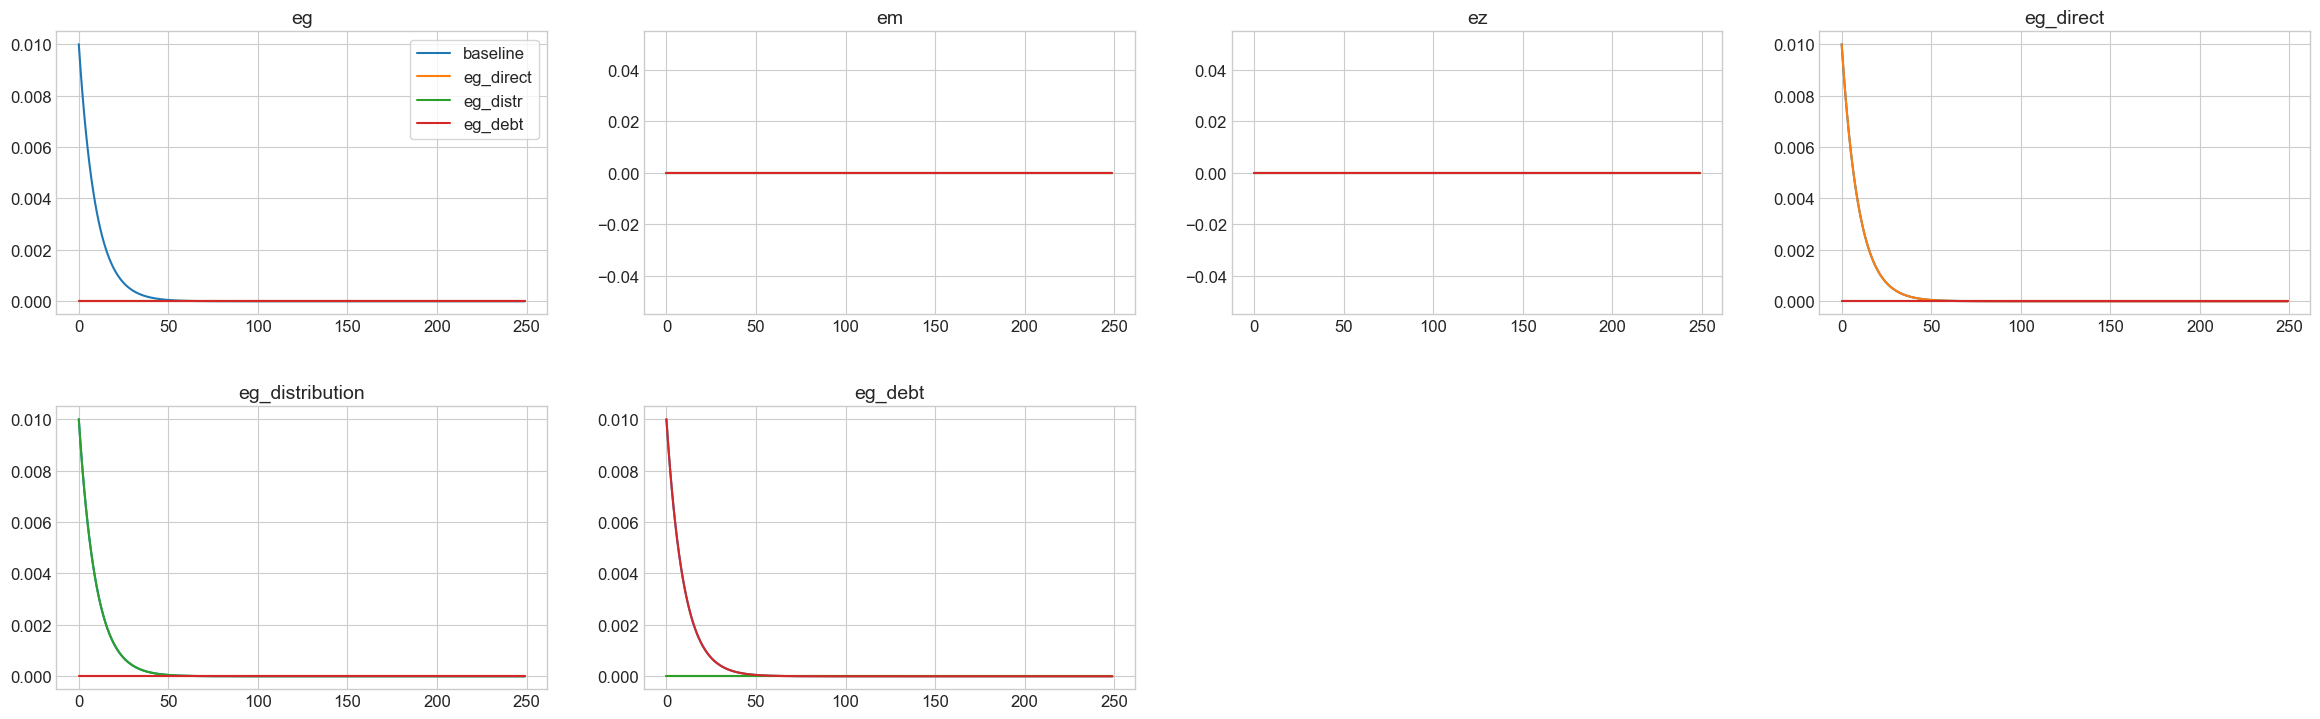


### varnames ###


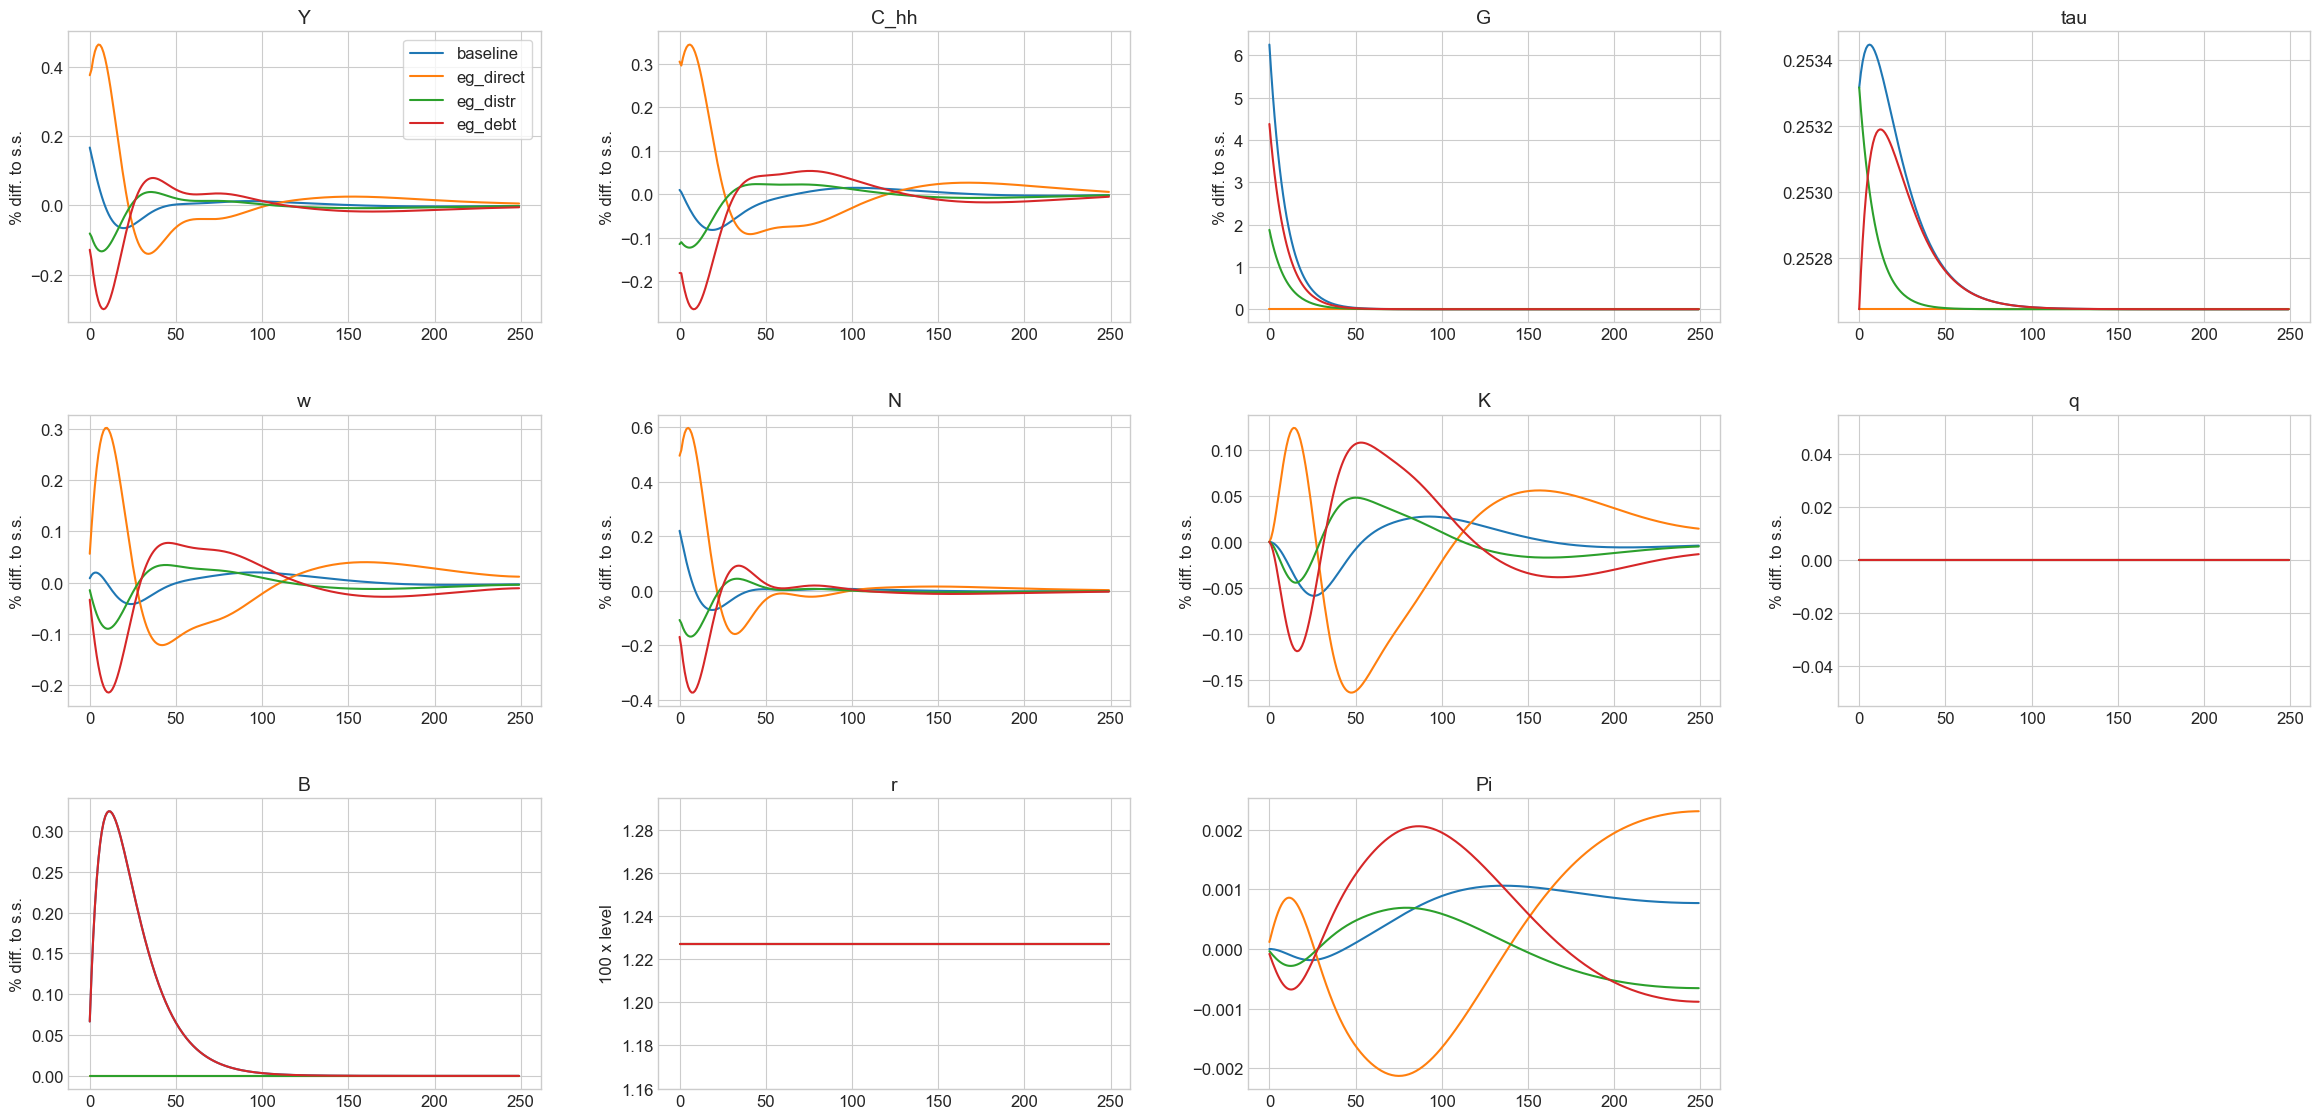

In [11]:
models = [model, model_eg_direct, model_eg_distribution, model_eg_debt]
labels = ['baseline', 'eg_direct', 'eg_distr', 'eg_debt']
paths = ['Y', 'C_hh', 'G', 'tau', 'w', 'N', 'K', 'q', 'B', 'r', 'Pi']
lvl_value = ['eg', 'eg_direct', 'eg_distribution', 'eg_debt', 'ez', 'em',  'r', 'tau', 'Pi']
facs = {'r':100}
model.compare_IRFs(models, labels, paths, lvl_value=lvl_value, facs=facs,
                   do_linear=True, do_non_linear=False, do_targets=False)

In [25]:
model_eg_direct.IRF['G']

array([1.60000000e-03, 1.44000000e-03, 1.29600000e-03, 1.16640000e-03,
       1.04976000e-03, 9.44784000e-04, 8.50305600e-04, 7.65275040e-04,
       6.88747536e-04, 6.19872782e-04, 5.57885504e-04, 5.02096954e-04,
       4.51887258e-04, 4.06698533e-04, 3.66028679e-04, 3.29425811e-04,
       2.96483230e-04, 2.66834907e-04, 2.40151416e-04, 2.16136275e-04,
       1.94522647e-04, 1.75070383e-04, 1.57563344e-04, 1.41807010e-04,
       1.27626309e-04, 1.14863678e-04, 1.03377310e-04, 9.30395792e-05,
       8.37356213e-05, 7.53620592e-05, 6.78258532e-05, 6.10432679e-05,
       5.49389411e-05, 4.94450470e-05, 4.45005423e-05, 4.00504881e-05,
       3.60454393e-05, 3.24408953e-05, 2.91968058e-05, 2.62771252e-05,
       2.36494127e-05, 2.12844714e-05, 1.91560243e-05, 1.72404219e-05,
       1.55163797e-05, 1.39647417e-05, 1.25682675e-05, 1.13114408e-05,
       1.01802967e-05, 9.16226704e-06, 8.24604033e-06, 7.42143630e-06,
       6.67929267e-06, 6.01136340e-06, 5.41022706e-06, 4.86920436e-06,
      

In [34]:
model_eg_direct.G_U[500:503,750:1000] @ model.IRF['eg_direct']

array([-0.43553614, -0.58568067, -0.6968655 ])

In [30]:
print(model.G_U.shape)
print(model.shocks)
print(model.unknowns)

(1250, 1500)
['eg', 'em', 'ez', 'eg_direct', 'eg_distribution', 'eg_debt']
['r', 'w', 'Y', 'Ip', 'Q']


In [15]:
[k for k in model.jac.keys() if 'Y' in k[0]]

[('clearing_Y', 'r'),
 ('clearing_Y', 'w'),
 ('clearing_Y', 'Y'),
 ('clearing_Y', 'Ip'),
 ('clearing_Y', 'Q'),
 ('clearing_Y', 'eg'),
 ('clearing_Y', 'em'),
 ('clearing_Y', 'ez'),
 ('clearing_Y', 'eg_direct'),
 ('clearing_Y', 'eg_distribution'),
 ('clearing_Y', 'eg_debt'),
 ('Y', 'r'),
 ('Y', 'w'),
 ('Y', 'Y'),
 ('Y', 'Ip'),
 ('Y', 'Q'),
 ('Y', 'eg'),
 ('Y', 'em'),
 ('Y', 'ez'),
 ('Y', 'eg_direct'),
 ('Y', 'eg_distribution'),
 ('Y', 'eg_debt')]

In [16]:
model.varlist

['A',
 'B',
 'clearing_A',
 'clearing_L',
 'clearing_C',
 'clearing_Y',
 'Div_int',
 'Div_k',
 'Div',
 'eg',
 'eg_direct',
 'eg_distribution',
 'eg_debt',
 'ez',
 'em',
 'fisher_res',
 'G',
 'i',
 'I',
 'invest_res',
 'Ip',
 'K',
 'L',
 'N',
 'p_eq',
 'p_int',
 'p_k',
 'p_share',
 'Pi_increase',
 'Pi_w_increase',
 'Pi_w',
 'Pi',
 'psi',
 'q',
 'Q',
 'qB',
 'r',
 'ra',
 'rk',
 'rl',
 's_w',
 's',
 'tau',
 'wN',
 'valuation_res',
 'w_res',
 'w',
 'Y',
 'Z',
 'C_hh',
 'L_hh',
 'A_hh',
 'UCE_hh']

In [17]:
for k in model.jac.keys():
    if 'Y' == k[0]:
        print(f"{k}, only zeros: {np.isclose(model.jac[k], 0.0).all()}")

('Y', 'r'), only zeros: True
('Y', 'w'), only zeros: True
('Y', 'Y'), only zeros: False
('Y', 'Ip'), only zeros: True
('Y', 'Q'), only zeros: True
('Y', 'eg'), only zeros: True
('Y', 'em'), only zeros: True
('Y', 'ez'), only zeros: True
('Y', 'eg_direct'), only zeros: True
('Y', 'eg_distribution'), only zeros: True
('Y', 'eg_debt'), only zeros: True


In [18]:
model.jac.keys()

dict_keys([('A', 'r'), ('A', 'w'), ('A', 'Y'), ('A', 'Ip'), ('A', 'Q'), ('A', 'eg'), ('A', 'em'), ('A', 'ez'), ('A', 'eg_direct'), ('A', 'eg_distribution'), ('A', 'eg_debt'), ('B', 'r'), ('B', 'w'), ('B', 'Y'), ('B', 'Ip'), ('B', 'Q'), ('B', 'eg'), ('B', 'em'), ('B', 'ez'), ('B', 'eg_direct'), ('B', 'eg_distribution'), ('B', 'eg_debt'), ('clearing_A', 'r'), ('clearing_A', 'w'), ('clearing_A', 'Y'), ('clearing_A', 'Ip'), ('clearing_A', 'Q'), ('clearing_A', 'eg'), ('clearing_A', 'em'), ('clearing_A', 'ez'), ('clearing_A', 'eg_direct'), ('clearing_A', 'eg_distribution'), ('clearing_A', 'eg_debt'), ('clearing_L', 'r'), ('clearing_L', 'w'), ('clearing_L', 'Y'), ('clearing_L', 'Ip'), ('clearing_L', 'Q'), ('clearing_L', 'eg'), ('clearing_L', 'em'), ('clearing_L', 'ez'), ('clearing_L', 'eg_direct'), ('clearing_L', 'eg_distribution'), ('clearing_L', 'eg_debt'), ('clearing_C', 'r'), ('clearing_C', 'w'), ('clearing_C', 'Y'), ('clearing_C', 'Ip'), ('clearing_C', 'Q'), ('clearing_C', 'eg'), ('clear